/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


=== Geo Assignment Analysis ===

Daily Dataset:
Control Geos: 92
Treatment Geos: 92
Total Geos: 184

Weekly Dataset:
Control Geos: 104
Treatment Geos: 104
Total Geos: 208

Overlap Analysis:
Common Geos: 184
Daily-only Geos: 0
Weekly-only Geos: 24

Assignment Agreement:
Matching Assignments: 90
Assignment Match Rate: 48.91%

Assignment Confusion Matrix:
Weekly Assignment  control  treatment
Daily Assignment                     
control                 45         47
treatment               47         45

Group Consistency Analysis:
Control Groups Jaccard Similarity: 29.80%
Treatment Groups Jaccard Similarity: 29.80%
Direct Match Consistency: 48.91%
Inverted Match Consistency: 51.09%
Rand Index (pair agreement): 49.75%
Assignments potentially inverted: True


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:255: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


TypeError: No matching signature found

<Figure size 1200x600 with 0 Axes>

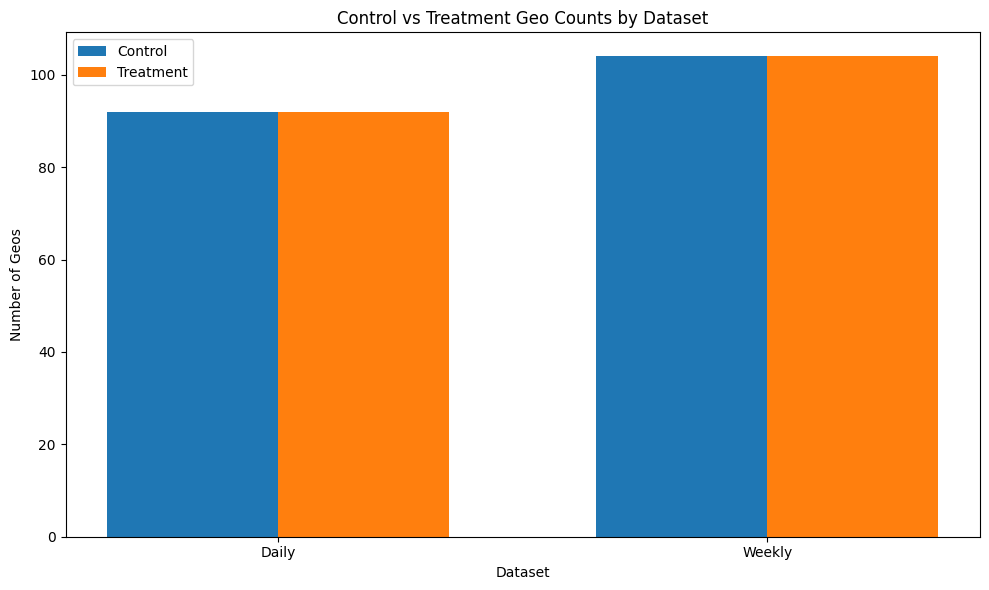

<Figure size 1000x600 with 0 Axes>

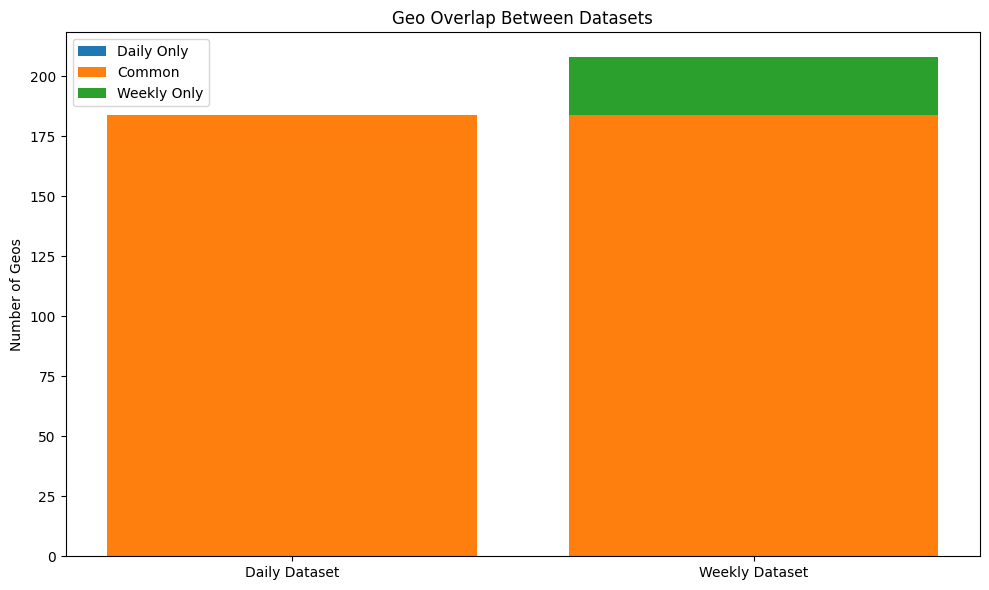

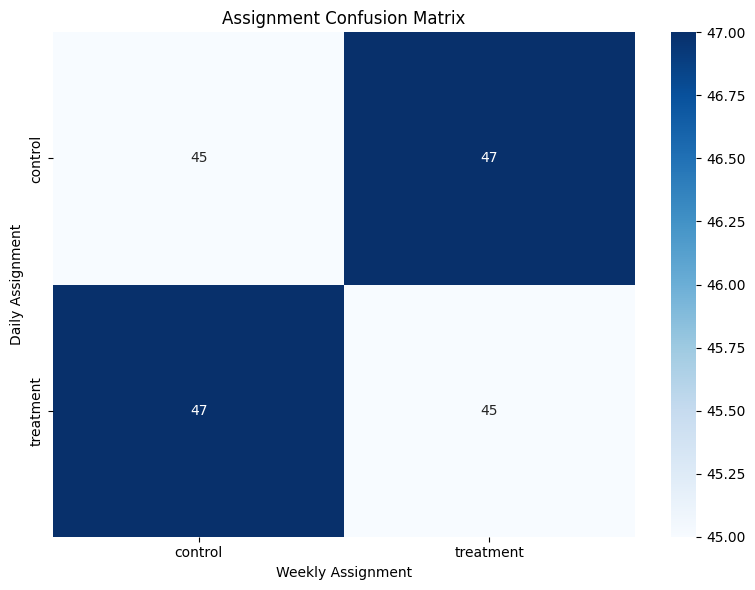

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the two datasets
weekly_data = pd.read_csv('../output/client1/design/data/geo_assignments.csv')
daily_data = pd.read_csv('../output/client1_daily//design/data/geo_assignments.csv')

# Rename columns to distinguish between datasets
daily_data.columns = ['geo', 'daily_assignment']
weekly_data.columns = ['geo', 'weekly_assignment']

# Merge datasets on geo ID to compare assignments
merged_data = pd.merge(daily_data, weekly_data, on='geo', how='outer')

# Function to analyze and compare the datasets
def analyze_geo_assignments(daily_df, weekly_df, merged_df):
    results = {}
    
    # 1. Count total control and treatment geos for daily data
    daily_counts = daily_df['daily_assignment'].value_counts()
    results['daily_control_count'] = daily_counts.get('control', 0)
    results['daily_treatment_count'] = daily_counts.get('treatment', 0)
    results['daily_total'] = len(daily_df)
    
    # 2. Count total control and treatment geos for weekly data
    weekly_counts = weekly_df['weekly_assignment'].value_counts()
    results['weekly_control_count'] = weekly_counts.get('control', 0)
    results['weekly_treatment_count'] = weekly_counts.get('treatment', 0)
    results['weekly_total'] = len(weekly_df)
    
    # 3. Analyze overlap between the two datasets
    common_geos = set(daily_df['geo']).intersection(set(weekly_df['geo']))
    results['common_geos_count'] = len(common_geos)
    results['daily_only_count'] = len(set(daily_df['geo']) - set(weekly_df['geo']))
    results['weekly_only_count'] = len(set(weekly_df['geo']) - set(daily_df['geo']))
    
    # 4. For common geos, check if assignments match
    # Filter merged data to only include rows that exist in both datasets
    common_assignments = merged_df.dropna()
    
    # Calculate agreement rate
    common_assignments['match'] = common_assignments['daily_assignment'] == common_assignments['weekly_assignment']
    results['assignment_match_count'] = common_assignments['match'].sum()
    results['assignment_match_rate'] = results['assignment_match_count'] / len(common_assignments) if len(common_assignments) > 0 else 0
    
    # 5. Create a confusion matrix for the assignments
    # Create a cross-tabulation of assignments
    if len(common_assignments) > 0:
        assignment_matrix = pd.crosstab(
            common_assignments['daily_assignment'], 
            common_assignments['weekly_assignment'],
            rownames=['Daily Assignment'],
            colnames=['Weekly Assignment']
        )
        results['assignment_matrix'] = assignment_matrix
    else:
        results['assignment_matrix'] = pd.DataFrame()
    
    return results

# Run the analysis
analysis_results = analyze_geo_assignments(daily_data, weekly_data, merged_data)

# Print the results
print("=== Geo Assignment Analysis ===")
print("\nDaily Dataset:")
print(f"Control Geos: {analysis_results['daily_control_count']}")
print(f"Treatment Geos: {analysis_results['daily_treatment_count']}")
print(f"Total Geos: {analysis_results['daily_total']}")

print("\nWeekly Dataset:")
print(f"Control Geos: {analysis_results['weekly_control_count']}")
print(f"Treatment Geos: {analysis_results['weekly_treatment_count']}")
print(f"Total Geos: {analysis_results['weekly_total']}")

print("\nOverlap Analysis:")
print(f"Common Geos: {analysis_results['common_geos_count']}")
print(f"Daily-only Geos: {analysis_results['daily_only_count']}")
print(f"Weekly-only Geos: {analysis_results['weekly_only_count']}")

print("\nAssignment Agreement:")
print(f"Matching Assignments: {analysis_results['assignment_match_count']}")
print(f"Assignment Match Rate: {analysis_results['assignment_match_rate']:.2%}")

print("\nAssignment Confusion Matrix:")
print(analysis_results['assignment_matrix'])

# Calculate similarity metrics for group consistency
def analyze_group_consistency(daily_df, weekly_df):
    # Get sets of control and treatment geos for both datasets
    daily_control = set(daily_df[daily_df['daily_assignment'] == 'control']['geo'])
    daily_treatment = set(daily_df[daily_df['daily_assignment'] == 'treatment']['geo'])
    
    weekly_control = set(weekly_df[weekly_df['weekly_assignment'] == 'control']['geo'])
    weekly_treatment = set(weekly_df[weekly_df['weekly_assignment'] == 'treatment']['geo'])
    
    # Calculate Jaccard similarity for direct group matching
    # Jaccard = |intersection| / |union|
    control_intersection = len(daily_control.intersection(weekly_control))
    control_union = len(daily_control.union(weekly_control))
    control_jaccard = control_intersection / control_union if control_union > 0 else 0
    
    treatment_intersection = len(daily_treatment.intersection(weekly_treatment))
    treatment_union = len(daily_treatment.union(weekly_treatment))
    treatment_jaccard = treatment_intersection / treatment_union if treatment_union > 0 else 0
    
    # Calculate group consistency regardless of label
    # Option 1: daily_control matches with weekly_control, daily_treatment matches with weekly_treatment
    option1_consistency = (control_intersection + treatment_intersection) / len(set(daily_df['geo']).intersection(set(weekly_df['geo'])))
    
    # Option 2: daily_control matches with weekly_treatment, daily_treatment matches with weekly_control
    control_treatment_match = len(daily_control.intersection(weekly_treatment))
    treatment_control_match = len(daily_treatment.intersection(weekly_control))
    option2_consistency = (control_treatment_match + treatment_control_match) / len(set(daily_df['geo']).intersection(set(weekly_df['geo'])))
    
    # Rand Index calculation (measure of similarity between two clusterings)
    # For common geos, count pairs that are grouped together in both datasets or separate in both
    common_geos = list(set(daily_df['geo']).intersection(set(weekly_df['geo'])))
    
    # Create lookup dictionaries for faster access
    daily_assignments = dict(zip(daily_df['geo'], daily_df['daily_assignment']))
    weekly_assignments = dict(zip(weekly_df['geo'], weekly_df['weekly_assignment']))
    
    total_pairs = 0
    agreed_pairs = 0
    
    for i in range(len(common_geos)):
        for j in range(i+1, len(common_geos)):
            geo_i, geo_j = common_geos[i], common_geos[j]
            
            # Check if pair is in same group in daily
            daily_same_group = daily_assignments[geo_i] == daily_assignments[geo_j]
            
            # Check if pair is in same group in weekly
            weekly_same_group = weekly_assignments[geo_i] == weekly_assignments[geo_j]
            
            # Pairs agree if both are in same group or both in different groups
            if daily_same_group == weekly_same_group:
                agreed_pairs += 1
            
            total_pairs += 1
    
    rand_index = agreed_pairs / total_pairs if total_pairs > 0 else 0
    
    # Check if assignments might be inverted
    inverted_match_rate = option2_consistency
    direct_match_rate = option1_consistency
    is_potentially_inverted = inverted_match_rate > direct_match_rate
    
    return {
        'control_jaccard': control_jaccard,
        'treatment_jaccard': treatment_jaccard,
        'direct_match_consistency': option1_consistency,
        'inverted_match_consistency': option2_consistency,
        'rand_index': rand_index,
        'potentially_inverted': is_potentially_inverted
    }

# Calculate and print group consistency metrics
consistency_results = analyze_group_consistency(daily_data, weekly_data)
print("\nGroup Consistency Analysis:")
print(f"Control Groups Jaccard Similarity: {consistency_results['control_jaccard']:.2%}")
print(f"Treatment Groups Jaccard Similarity: {consistency_results['treatment_jaccard']:.2%}")
print(f"Direct Match Consistency: {consistency_results['direct_match_consistency']:.2%}")
print(f"Inverted Match Consistency: {consistency_results['inverted_match_consistency']:.2%}")
print(f"Rand Index (pair agreement): {consistency_results['rand_index']:.2%}")
print(f"Assignments potentially inverted: {consistency_results['potentially_inverted']}")

# Create visualizations for the analysis
def create_visualizations(daily_df, weekly_df, merged_df, analysis_results):
    # 1. Bar chart comparing control/treatment counts
    plt.figure(figsize=(12, 6))
    
    # Dataset counts
    datasets = ['Daily', 'Weekly']
    control_counts = [analysis_results['daily_control_count'], analysis_results['weekly_control_count']]
    treatment_counts = [analysis_results['daily_treatment_count'], analysis_results['weekly_treatment_count']]
    
    x = np.arange(len(datasets))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, control_counts, width, label='Control')
    ax.bar(x + width/2, treatment_counts, width, label='Treatment')
    
    ax.set_xlabel('Dataset')
    ax.set_ylabel('Number of Geos')
    ax.set_title('Control vs Treatment Geo Counts by Dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(datasets)
    ax.legend()
    
    plt.tight_layout()
    plt.savefig('geo_counts_comparison.png')
    
    # 2. Venn diagram-like representation for overlap
    plt.figure(figsize=(10, 6))
    
    # Create data for a Venn diagram-like visualization
    daily_only = analysis_results['daily_only_count']
    weekly_only = analysis_results['weekly_only_count']
    common = analysis_results['common_geos_count']
    
    # Create a stacked bar chart to represent the overlap
    overlap_data = [
        [daily_only, 0],
        [common, common],
        [0, weekly_only]
    ]
    
    labels = ['Daily Only', 'Common', 'Weekly Only']
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the stacked bars
    bottom = np.zeros(2)
    for i, row in enumerate(overlap_data):
        ax.bar(['Daily Dataset', 'Weekly Dataset'], row, bottom=bottom, label=labels[i])
        bottom += row
    
    ax.set_title('Geo Overlap Between Datasets')
    ax.set_ylabel('Number of Geos')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig('geo_overlap.png')
    
    # 3. Heatmap for assignment confusion matrix if there are common geos
    if 'assignment_matrix' in analysis_results and not analysis_results['assignment_matrix'].empty:
        plt.figure(figsize=(8, 6))
        sns.heatmap(analysis_results['assignment_matrix'], annot=True, cmap='Blues', fmt='d')
        plt.title('Assignment Confusion Matrix')
        plt.tight_layout()
        plt.savefig('assignment_confusion_matrix.png')

# Create visualizations
create_visualizations(daily_data, weekly_data, merged_data, analysis_results)

# Additional analysis: Check for patterns in geo IDs that might explain differences
# For example, are certain ranges of geo IDs more likely to have different assignments?

def analyze_geo_id_patterns(merged_df):
    # Filter to only include common geos with different assignments
    discrepancies = merged_df[
        (~merged_df['daily_assignment'].isna()) & 
        (~merged_df['weekly_assignment'].isna()) & 
        (merged_df['daily_assignment'] != merged_df['weekly_assignment'])
    ]
    
    if len(discrepancies) == 0:
        return "No discrepancies found between common geos."
    
    # Check if discrepancies are related to geo ID ranges
    discrepancies['geo_range'] = pd.cut(discrepancies['geo'], bins=5)
    range_counts = discrepancies['geo_range'].value_counts().sort_index()
    
    # Check if certain ranges have more discrepancies
    total_by_range = merged_df['geo_range'].value_counts().sort_index()
    discrepancy_rate_by_range = (range_counts / total_by_range.loc[range_counts.index]).fillna(0)
    
    return {
        'discrepancy_count': len(discrepancies),
        'discrepancies_by_range': range_counts,
        'discrepancy_rate_by_range': discrepancy_rate_by_range
    }

# Add geo range for the merged data
merged_data['geo_range'] = pd.cut(merged_data['geo'], bins=5)

# Run pattern analysis
pattern_results = analyze_geo_id_patterns(merged_data)
print("\nGeo ID Pattern Analysis:")
if isinstance(pattern_results, str):
    print(pattern_results)
else:
    print(f"Total discrepancies: {pattern_results['discrepancy_count']}")
    print("\nDiscrepancies by geo ID range:")
    print(pattern_results['discrepancies_by_range'])
    print("\nDiscrepancy rate by geo ID range:")
    print(pattern_results['discrepancy_rate_by_range'])

# Export detailed results to CSV for further analysis
merged_data.to_csv('geo_assignment_comparison.csv', index=False)
print("\nDetailed comparison exported to 'geo_assignment_comparison.csv'")